In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP, GraphPPL, RxInfer, Distributions, LinearAlgebra, Plots, Random
using BenchmarkTools
import KernelFunctions: Matern52Kernel, with_lengthscale

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **



In [3]:
Random.seed!(3)
xmin, xmax = -3, 3  # Bounds of the data
N = 200# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

k_func(θ) =  with_lengthscale(Matern52Kernel(),θ) 
meanfunc   = (x) -> 0.0;
θ_init = 1.0 #our initial lengthscale
log_θ_init = log(θ_init)

cov_strategy = CovarianceMatrixStrategy(DTC(50))

CovarianceMatrixStrategy{DeterministicTrainingConditional{MersenneTwister}}(DeterministicTrainingConditional{MersenneTwister}(50, MersenneTwister(1), [1.0;;], [1.0;;], [1.0;;], [1.0;;], [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [4]:
# test new thing
@model function gp_regress(n,kernelfunc,meanfunc,train,test,log_θ,strategy)
    y = datavar(Float64,n)
    x = randomprocess(test,train,strategy)
    ### change here 
    x ~ GaussianProcess(meanfunc,kernelfunc, log_θ)
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i)}
    end
end

In [5]:
@constraints function gpconstraints()   
    q(x,γ) = q(x)q(γ)
end

gpconstraints (generic function with 1 method)

In [11]:
nits = 10
iresult = inference(
    model = gp_regress(length(ytrain), k_func, meanfunc, xtrain,xtest,log_θ_init,cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    # free_energy = true,
    showprogress = true
)

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Inference results:
  Posteriors       | available for (γ, x)


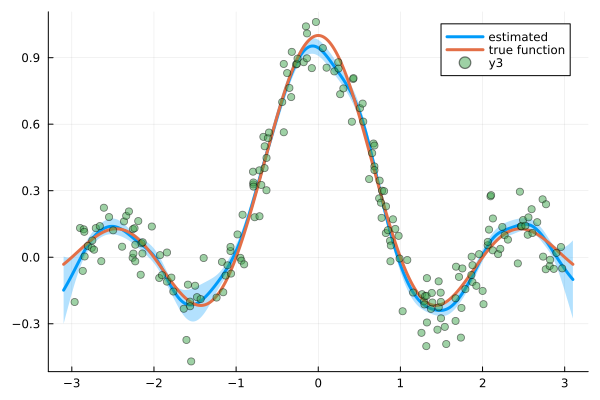

In [19]:
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5)

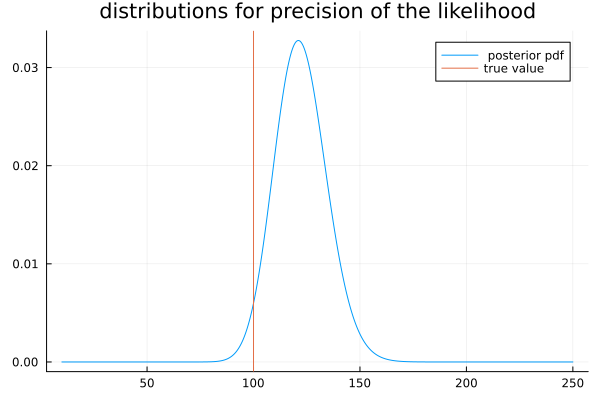

In [20]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)

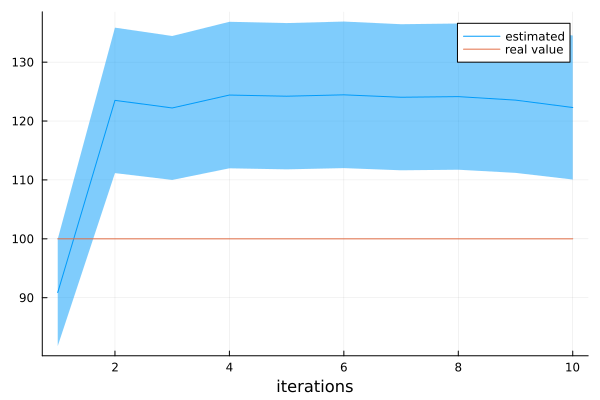

In [21]:
from = 1
to   = nits
plot(collect(from:to),mean.(iresult.posteriors[:γ])[from:to],ribbon=std.(iresult.posteriors[:γ])[from:to],label="estimated")
plot!(collect(from:to),precision*ones(to-from+1),label="real value")
xlabel!("iterations")

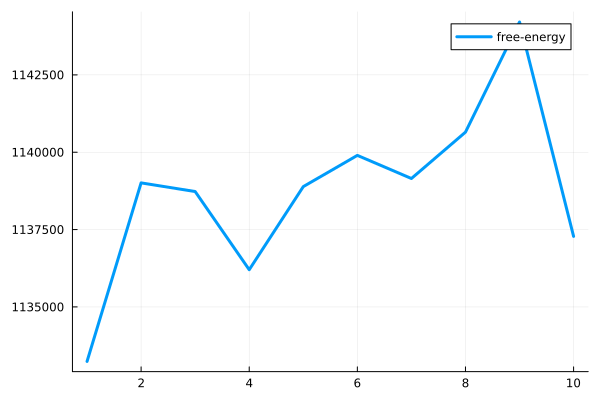

In [22]:
plot(iresult.free_energy,linewidth=3.0,label="free-energy")

In [12]:
#After improvement
@benchmark inference(
    model = gp_regress(length($ytrain), $k_func, $meanfunc, $xtrain,$xtest,$log_θ_init,$cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = gpconstraints(),
    iterations = $nits,  
    data  = (y = $ytrain,)
)

BenchmarkTools.Trial: 42 samples with 1 evaluation.
 Range (min … max):  113.015 ms … 132.019 ms  ┊ GC (min … max): 0.00% … 7.60%
 Time  (median):     121.603 ms               ┊ GC (median):    4.72%
 Time  (mean ± σ):   121.931 ms ±   4.687 ms  ┊ GC (mean ± σ):  3.74% ± 2.95%

      ▃         █   ▃     ▃ █ ▃ ▃  █       █   ▃                 
  ▇▁▇▁█▁▁▁▁▁▇▇▁▁█▁▁▇█▇▁▇▇▇█▁█▁█▁█▇▁█▁▇▁▁▁▁▁█▇▇▁█▇▇▁▁▁▁▇▁▁▁▁▁▁▇▇ ▁
  113 ms           Histogram: frequency by time          132 ms <

 Memory estimate: 120.69 MiB, allocs estimate: 209820.

In [ ]:
# BenchmarkTools.Trial: 41 samples with 1 evaluation.
#  Range (min … max):  109.213 ms … 148.934 ms  ┊ GC (min … max): 0.00% … 5.50%
#  Time  (median):     125.203 ms               ┊ GC (median):    5.51%
#  Time  (mean ± σ):   124.611 ms ±   8.523 ms  ┊ GC (mean ± σ):  4.09% ± 3.25%

#            ▄   ▄▁ ▁       ██▁    ▁ ▁ ▄                           
#   ▆▁▁▁▆▁▆▆▁█▁▁▆██▁█▁▆▆▁▆▁▁███▆▁▁▁█▆█▁█▁▆▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▆▁▁▁▁▆ ▁
#   109 ms           Histogram: frequency by time          149 ms <

#  Memory estimate: 124.52 MiB, allocs estimate: 209770.